In [1]:
startDate   =  "1995-10-01"
endDate     =  "2024-09-30"
model_months=  [6 ,7,8]
model_site  = [
    "13311450"  
              ]
idv         = [ "00060_Mean" ,"tmean" ,"Days_Since_October_1st" ]

In [2]:
df_cleaned_csv = "df_cleaned.csv" 
model_df_site_csv ="model_df_site.csv"
sorted_df_csv= "sorted_df.csv"
sorted_df_var_csv ="sorted_df_var.csv"

In [3]:
from dataretrieval import nwis
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import acf
#!pip uninstall scikit-learn -y
#!pip install scikit-learn 
import sklearn
# Print the version of scikit-learn
print(sklearn.__version__)
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

1.4.2


In [4]:
shared_url = "https://drive.google.com/file/d/1z9w4rk21CCbbuOjwsru1pgkiOsYgVX6h/view?usp=share_link"
file_id = shared_url.split('/d/')[1].split('/')[0]
download_url = f"https://drive.google.com/uc?id={file_id}"
prism_df = pd.read_csv(download_url)

prism_df['date'] = pd.to_datetime( prism_df['date']) 
def days_since_october_first(date):
    october_first = pd.Timestamp(year=date.year, month=10, day=1)
    days_difference = (date - october_first).days   
    return days_difference if days_difference >= 0 else days_difference + 365
prism_df['Days_Since_October_1st'] =  prism_df['date'].apply(days_since_october_first)
prism_df[ "rad_d"   ] = 2 * np.pi * prism_df[ "Days_Since_October_1st"   ] /365
prism_df["site_no"] =prism_df["site_no"].astype(str)

# Add a leading 0 to strings with exactly 7 characters
prism_df['site_no'] = prism_df['site_no'].apply(lambda x: '0' + x if len(x) == 7 else x)
prism_df["site_no"] =prism_df["site_no"].astype(str)


prism_df['Date'] = prism_df['date'].dt.date

In [5]:
site_info = nwis.get_info(sites= model_site )
site_info_df = pd.DataFrame( site_info[0] )
site_info_df["site_no"]=site_info_df["site_no"].astype(str)
columns_to_save = ['site_no', 'dec_lat_va', 'dec_long_va', 'drain_area_va' 
                   ,   'alt_va'
                  ]
filtered_df = site_info_df[columns_to_save]
#print(filtered_df)

parameterCode = ["00010","00060"  ]
dailyStreamtemp = nwis.get_dv(sites= model_site
                              , parameterCd=parameterCode, start=startDate, end=endDate) 
dailyStreamtemp_df = pd.DataFrame( dailyStreamtemp[0] )
dailyStreamtemp_df = dailyStreamtemp_df.reset_index()
dailyStreamtemp_df['Date'] = dailyStreamtemp_df['datetime'].dt.date
dailyStreamtemp_df['Month'] = dailyStreamtemp_df['datetime'].dt.month
dailyStreamtemp_df['Year'] = dailyStreamtemp_df['datetime'].dt.year
dailyStreamtemp_df = dailyStreamtemp_df[ dailyStreamtemp_df['Month'].isin( model_months  )    ]
print( dailyStreamtemp_df.head() )

                     datetime   site_no  00010_Maximum 00010_Maximum_cd  \
258 2012-06-01 00:00:00+00:00  13311450            9.1                A   
259 2012-06-02 00:00:00+00:00  13311450            8.1                A   
260 2012-06-03 00:00:00+00:00  13311450            7.0                A   
261 2012-06-04 00:00:00+00:00  13311450            8.5                A   
262 2012-06-05 00:00:00+00:00  13311450            5.5                A   

     00010_Minimum 00010_Minimum_cd  00010_Mean 00010_Mean_cd  00060_Mean  \
258            4.1                A         6.0             A        85.1   
259            4.5                A         5.7             A       108.0   
260            4.3                A         5.4             A       119.0   
261            4.2                A         5.8             A       124.0   
262            3.3                A         4.1             A       142.0   

    00060_Mean_cd        Date  Month  Year  
258             A  2012-06-01      6  201

In [6]:
prism_df = prism_df[['tmean' , "site_no", 'Date', "rad_d", "Days_Since_October_1st" ]]
dailyStreamtemp_df = dailyStreamtemp_df[[    'Date',
       'site_no',  
  '00010_Mean', '00060_Mean', 
       'Month', 'Year' ]]
result = pd.merge(prism_df, dailyStreamtemp_df, on=['Date','site_no'], how='inner')
#print(result)

#print(result.columns)

# Count the number of NaN values in each column
na_count = result.isna().sum()
# Print the result
print(na_count)
# Drop rows with any NaN values
df_cleaned = result.dropna()
# Print the cleaned DataFrame
print(df_cleaned.head())
# Count the number of NaN values in each column
na_count = df_cleaned.isna().sum()
# Print the result
print(na_count )

tmean                      0
site_no                    0
Date                       0
rad_d                      0
Days_Since_October_1st     0
00010_Mean                98
00060_Mean                 0
Month                      0
Year                       0
dtype: int64
       tmean   site_no        Date     rad_d  Days_Since_October_1st  \
0  11.892000  13311450  2012-06-01  4.183052                     243   
1  10.656000  13311450  2012-06-02  4.200266                     244   
2  11.382001  13311450  2012-06-03  4.217481                     245   
3  13.261001  13311450  2012-06-04  4.234695                     246   
4   2.307000  13311450  2012-06-05  4.251909                     247   

   00010_Mean  00060_Mean  Month  Year  
0         6.0        85.1      6  2012  
1         5.7       108.0      6  2012  
2         5.4       119.0      6  2012  
3         5.8       124.0      6  2012  
4         4.1       142.0      6  2012  
tmean                     0
site_no            

In [7]:
df_site_pred_test_0 = pd.DataFrame({
    'site': [0000],
#    'Date' : [ '' ],
    'y_pred_best': [0.0],
    'y_test': [0.0]
})




In [8]:
var = pd.DataFrame({
    'site': [0000],
    'std_dev_st': [0.0],
    'cv_q': [0.0],
    'inter_cv_q': [0.0],
    'inter_cv_st' :[0.0],
    'range': [0.0],
    'autocorr_t_1': [0.0],
    'autocorr_t_2': [0.0]
})

In [9]:
params = {
    "n_estimators":   100 , #default
    
    

    'criterion': 'absolute_error',
    "max_depth":None,
    "random_state": 42
    , 'oob_score': True
}

param_grid = {
    #'bootstrap': [True],
    'max_depth': [5 ,10,  20, None ],
    #'max_features': [2, 3],
#    'min_samples_leaf': [3, 4, 5],
    #'min_samples_split': [8, 10, 12],
    'n_estimators': [50, 100,200 ]
    , "random_state": [42],

    'criterion': ['absolute_error']
    , 'oob_score': [True]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf
                           , param_grid = param_grid 
                         # ,cv = 3, n_jobs = -1, verbose = 2
                          )

In [10]:
bias_q = pd.DataFrame({
    'site': [0000],
    'Q1_obs': [0.0],
    'Q2_obs': [0.0],
    'Q3_obs': [0.0],
    'Q4_obs': [0.0],
    'Q1_bias': [0.0],
    'Q2_bias': [0.0],
    'Q3_bias': [0.0],
    'Q4_bias': [0.0]
})

In [11]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    #errors = abs(predictions - test_labels)
    r2 = r2_score(test_labels, predictions)
    #print(f'R-squared: {r2}')

    # Compute McFadden's pseudo R-squared
    #ll_model = model.llf  # Log-likelihood of the fitted model
    #ll_null = model.llnull  # Log-likelihood of the null model
   # pseudo_r2 = 1 - (ll_model / ll_null)
    #Adjusted R-squared, on the other hand, adjusts the R-squared value based on the number of predictors in the model. 

    # Number of samples and predictors
    n = test_features.shape[0]  # Number of test samples
    p = test_features.shape[1]  # Number of predictors

# Compute Adjusted R-squared
    pseudo_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    
    #pseudo_r2 = model.oob_score_

    mse = mean_squared_error(test_labels, predictions)

    bias = np.mean( predictions- test_labels)

    #print("Mean Error (Bias):", bias)
    
    rmse = np.sqrt(mse)
    RSS = np.sum(( test_labels  -  predictions) ** 2)
    TSS = np.sum(( test_labels  - np.mean( test_labels )) ** 2)
    NSE = 1 - (RSS / TSS)
    #print(f"Mean Squared Error: {mse}")
    #print(f"Root Mean Squared Error: {rmse}")

    # standard deviation ratio
    std_ratio = np.std(predictions) / np.std(test_labels)
    # correlation
    
    correlation = np.corrcoef(predictions, test_labels)[0, 1]
    
    return r2,pseudo_r2,mse,bias,rmse,NSE,std_ratio,correlation

In [12]:
evaluate_data = {
            "site": [  "" ],
            "number_of_obs": [  0 ], 
            'base_r2': [ 0.0 ],
            'grid_r2': [ 0.0],
            'base_pseudo_r2' :[0.0],
            'grid_pseudo_r2' :[0.0],
            'base_mse': [ 0.0],
            'grid_mse': [ 0.0],
            'base_bias': [ 0.0],
            'grid_bias': [ 0.0],
            'base_rmse': [ 0.0],
            'grid_rmse':[ 0.0 ],
            'base_NSE': [ 0.0],
            'grid_NSE':[ 0.0 ]
        }
evaluate_df = pd.DataFrame(evaluate_data)

for site in model_site:
    #print("site:", site)
    merged_df_wy=df_cleaned[df_cleaned['site_no']==site ]
    num_rows = merged_df_wy.shape[0]
    
    #var0['std_dev_st'] = np.std( merged_df_wy['00010_Mean'])
    #var0['range'] = np.max( merged_df_wy['00010_Mean']) - np.min( merged_df_wy['00010_Mean'])
    autocorr_values = acf( merged_df_wy['00010_Mean'], nlags= 5)  # Compute autocorrelation up to lag 10
    #var0['autocorr_t_1'] = autocorr_values[1]

  # Calculate mean and standard deviation
    q_mean = merged_df_wy['00060_Mean'].mean()
    q_std = merged_df_wy['00060_Mean'].std()
# Calculate Coefficient of Variation (CV)
    cv_q = q_std / q_mean

    grouped_stats_yr = merged_df_wy.groupby('Year')['00060_Mean'].agg( mean='mean' )
    inter_cv_q =   grouped_stats_yr['mean'].std() /  grouped_stats_yr['mean'].mean()
    #print(grouped_stats_yr['mean'] )
    #print(inter_cv_q)

    grouped_stats_yr_st = merged_df_wy.groupby('Year')['00010_Mean'].agg( mean='mean' )
    inter_cv_st =   grouped_stats_yr_st['mean'].std() /  grouped_stats_yr_st['mean'].mean()
    #print(grouped_stats_yr_st['mean'] )
    #print(inter_cv_st)

    var0 = pd.DataFrame({
    'site': [site],
    'std_dev_st': [ np.std( merged_df_wy['00010_Mean']) ],
    'cv_q': [  cv_q ],
        'inter_cv_q':[ inter_cv_q ],
        'inter_cv_st':[ inter_cv_st ],
    'range': [ np.max( merged_df_wy['00010_Mean']) - np.min( merged_df_wy['00010_Mean']) ],
    'autocorr_t_1': [ autocorr_values[1]],
    'autocorr_t_2': [ autocorr_values[2]]
    })
    
    var=pd.concat( [var0,var] )
    
    input=  merged_df_wy[  idv]
    
    if num_rows <90:
        print("stop:", site)
    else: 
        print( merged_df_wy['Date'].head() )
        X_train, X_test, y_train, y_test = train_test_split( input,  merged_df_wy['00010_Mean'], test_size=0.2, random_state=42)
        # Initialize the RandomForestRegressor model
        rf_model = RandomForestRegressor(**params)
        # Fit the model
        rf_model.fit(X_train, y_train)
        # Predict on the test set
        #y_pred_rf = rf_model.predict(X_test)
        #test_score_rf = np.zeros((params["n_estimators"],), dtype=np.float64)            
        # Evaluate the model
        #mse = mean_squared_error(y_test, y_pred_rf)
        #rmse = np.sqrt(mse)
        #print(f"Mean Squared Error: {mse}")
        #print(f"Root Mean Squared Error: {rmse}")
        # Plotting actual vs predicted values
        #plt.scatter(y_test, y_pred_rf, color='red'    )
        #plt.xlabel(' ')
        #plt.ylabel(' ')
        #plt.title( site)
        #plt.legend()
        #plt.show()

        # Fit the grid search to the data
        grid_search.fit( X_train, y_train )
        grid_search.best_params_
        best_grid = grid_search.best_estimator_
#print("best_grid:",best_grid)
#print("rf_model:",rf_model)
        grid_r2, grid_pseudo_r2, grid_mse, grid_bias,grid_rmse, grid_NSE , grid_std_ratio, grid_correlation= evaluate(best_grid, X_test, y_test )
        base_r2, base_pseudo_r2, base_mse, base_bias,base_rmse, base_NSE, base_std_ratio, base_correlation = evaluate( rf_model, X_test, y_test )
        evaluate_data = {
            "site": [  site ] ,
            "number_of_obs": [ num_rows ] ,
            'base_r2': [base_r2],
            'grid_r2': [grid_r2],
#pseudo
            'base_pseudo_r2': [base_pseudo_r2],
            'grid_pseudo_r2': [grid_pseudo_r2],
            
            'base_mse': [base_mse],
            'grid_mse': [grid_mse],
            'base_bias': [base_bias],
            'grid_bias': [grid_bias],
            'base_rmse': [base_rmse],
            'grid_rmse':[grid_rmse],
            'base_NSE': [  base_NSE],
            'grid_NSE':[ grid_NSE ],
           "base_std_ratio" : [base_std_ratio],
            
            "grid_std_ratio": [ grid_std_ratio ],
            "base_correlation":[ base_correlation ],
            "grid_correlation" : [ grid_correlation ]
        }
        evaluate_df0 = pd.DataFrame(evaluate_data)
        evaluate_df = pd.concat( [ evaluate_df , evaluate_df0 ] )

        y_pred_best = best_grid.predict(X_test)
        df_q = pd.DataFrame({
        "y_test": y_test,
        "y_pred_best": y_pred_best
        })
        quantiles = pd.qcut( y_test , q=4 , labels=["Q1", "Q2", "Q3", "Q4"])
        df_q['quantile'] = quantiles
        obs_by_quantile = df_q.groupby('quantile')['y_test'].mean()
        df_q['bias']=   df_q['y_pred_best'] - df_q['y_test']
        error_by_quantile = df_q.groupby('quantile')['bias'].mean()
        bias_q0=pd.DataFrame({
        "site": [site],  # Make sure it's a list so it can be added as a row
        
        "Q1_obs": [obs_by_quantile[0]],
        "Q2_obs": [obs_by_quantile[1]],
        "Q3_obs": [obs_by_quantile[2]],
        "Q4_obs": [obs_by_quantile[3]],
        
        "Q1_bias": [error_by_quantile[0]],
        "Q2_bias": [error_by_quantile[1]],
        "Q3_bias": [error_by_quantile[2]],
        "Q4_bias": [error_by_quantile[3]]
        })
        bias_q=pd.concat([bias_q,bias_q0])

        df_site_pred_test = pd.DataFrame({
            'site': site,
          #  'Date' : merged_df_wy['Date'],
            "y_test": y_test,
        "y_pred_best": y_pred_best
        })
        df_site_pred_test_0=pd.concat([ df_site_pred_test, df_site_pred_test_0])

#print(evaluate_df)

0    2012-06-01
1    2012-06-02
2    2012-06-03
3    2012-06-04
4    2012-06-05
Name: Date, dtype: object


C:\Users\taohuang\AppData\Local\Temp\ipykernel_6496\3517086136.py:126: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_by_quantile = df_q.groupby('quantile')['y_test'].mean()
C:\Users\taohuang\AppData\Local\Temp\ipykernel_6496\3517086136.py:128: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_quantile = df_q.groupby('quantile')['bias'].mean()
C:\Users\taohuang\AppData\Local\Temp\ipykernel_6496\3517086136.py:132: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access 

In [13]:



site_pred_test = df_site_pred_test_0[ df_site_pred_test_0['y_test']>0 ]

3.1
12.1
11.981000000000002
12.1


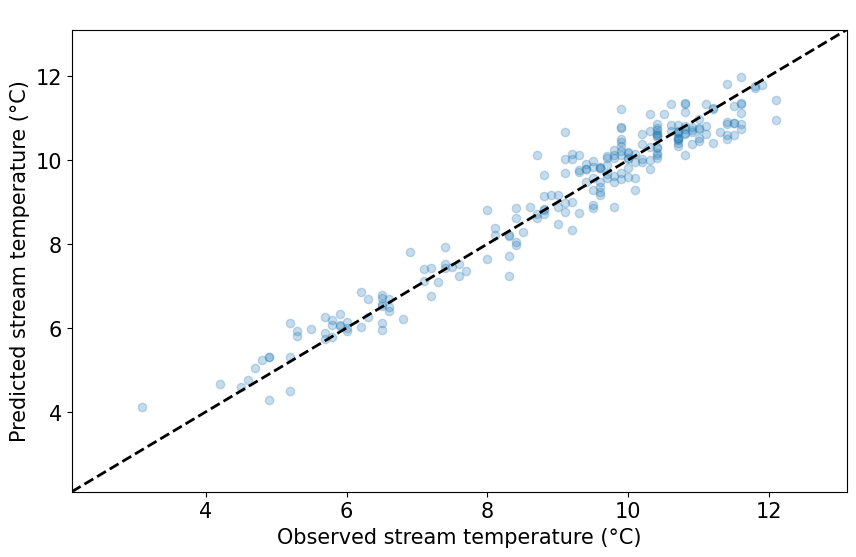

In [14]:
fontsize =15

min_1= site_pred_test[ 'y_test'].min( )
min_2= site_pred_test['y_pred_best'].min( )
min=np.min([min_1,min_2] )
print(min)

max_1= site_pred_test[ 'y_test'].max( )
print(max_1)
max_2= site_pred_test['y_pred_best'].max( )
print(max_2)
max=np.max([ max_1, max_2] )
print(max)

plt.figure(figsize=(10, 6))
plt.scatter( site_pred_test['y_test'],  site_pred_test['y_pred_best'], alpha=0.25)
plt.plot([ min -1 , max +1 ], [min -1 , max + 1 ], 'k--', lw=2)

plt.ylim( min -1 , max +1)
plt.xlim( min -1 , max +1)

plt.xticks( fontsize = fontsize )
plt.yticks( fontsize = fontsize )

plt.xlabel('Observed stream temperature (°C)' , fontsize = fontsize )
plt.ylabel('Predicted stream temperature (°C)' , fontsize = fontsize )
plt.title(' ')


plt.savefig('test_pred.png')


plt.show()

In [15]:
site_pred_test

,site,y_test,y_pred_best
44,13311450,9.5,8.9270
668,13311450,6.2,6.8540
56,13311450,10.5,11.0815
700,13311450,10.7,10.4775
928,13311450,5.7,5.7355
...,...,...,...
857,13311450,10.8,11.3530
813,13311450,10.8,11.3295
1010,13311450,10.2,10.0250
1056,13311450,10.4,10.1685


In [16]:
X_test

,00060_Mean,tmean,Days_Since_October_1st
44,32.70,14.762001,287
668,39.70,9.546900,267
56,17.70,19.470001,299
700,16.70,16.545500,299
928,125.00,10.932799,251
...,...,...,...
857,20.60,19.737900,272
813,12.60,20.512400,320
1010,12.20,17.438700,333
1056,18.90,15.745100,287


In [17]:
df_cleaned

,tmean,site_no,Date,rad_d,Days_Since_October_1st,00010_Mean,00060_Mean,Month,Year
0,11.892000,13311450,2012-06-01,4.183052,243,6.0,85.10,6,2012
1,10.656000,13311450,2012-06-02,4.200266,244,5.7,108.00,6,2012
2,11.382001,13311450,2012-06-03,4.217481,245,5.4,119.00,6,2012
3,13.261001,13311450,2012-06-04,4.234695,246,5.8,124.00,6,2012
4,2.307000,13311450,2012-06-05,4.251909,247,4.1,142.00,6,2012
...,...,...,...,...,...,...,...,...,...
1191,11.974700,13311450,2024-08-27,5.680688,330,8.8,9.77,8,2024
1192,7.881100,13311450,2024-08-28,5.697902,331,8.3,9.61,8,2024
1193,10.701050,13311450,2024-08-29,5.715116,332,7.7,9.56,8,2024
1194,13.306649,13311450,2024-08-30,5.732331,333,8.3,9.36,8,2024


C:\Users\taohuang\AppData\Local\Temp\ipykernel_6496\4259278984.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])


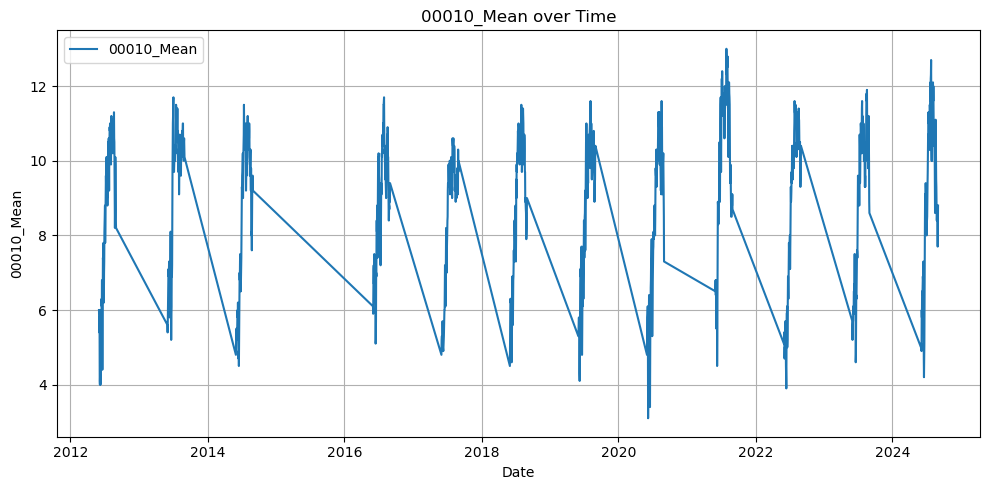

In [18]:
#import matplotlib.pyplot as plt

# Ensure 'Date' is in datetime format (if it's not already)
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df_cleaned['Date'], df_cleaned['00010_Mean'], label='00010_Mean')
plt.xlabel('Date')
plt.ylabel('00010_Mean')
plt.title('00010_Mean over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
#import pandas as pd

# Assuming you have your DataFrames df_cleaned and site_pred_test loaded

# Merge the DataFrames based on their row index
df_merged = pd.merge(df_cleaned, site_pred_test, left_index=True, right_index=True)

# The resulting DataFrame 'df_merged' will contain columns from both
# df_cleaned and site_pred_test, aligned by their row index.

# You can now work with the merged DataFrame 'df_merged'
print(df_merged.head())

        tmean   site_no       Date     rad_d  Days_Since_October_1st  \
3   13.261001  13311450 2012-06-04  4.234695                     246   
10   6.987000  13311450 2012-06-11  4.355194                     253   
12   8.068001  13311450 2012-06-13  4.389623                     255   
23  13.881001  13311450 2012-06-24  4.578979                     266   
30  14.428000  13311450 2012-07-01  4.699478                     273   

    00010_Mean  00060_Mean  Month  Year      site  y_test  y_pred_best  
3          5.8       124.0      6  2012  13311450     5.8       6.0620  
10         5.2        64.6      6  2012  13311450     5.2       6.1115  
12         6.0        66.9      6  2012  13311450     6.0       5.9155  
23         7.5        65.2      6  2012  13311450     7.5       7.4595  
30         8.3        40.4      7  2012  13311450     8.3       8.2015  


In [20]:
#import pandas as pd

# Merge the two DataFrames by index, keeping all rows (even with NA)
merged_df = pd.concat([df_cleaned, site_pred_test], axis=1)
merged_df

,tmean,site_no,Date,rad_d,Days_Since_October_1st,00010_Mean,00060_Mean,Month,Year,site,y_test,y_pred_best
0,11.892000,13311450,2012-06-01,4.183052,243,6.0,85.10,6,2012,NaN,NaN,NaN
1,10.656000,13311450,2012-06-02,4.200266,244,5.7,108.00,6,2012,NaN,NaN,NaN
2,11.382001,13311450,2012-06-03,4.217481,245,5.4,119.00,6,2012,NaN,NaN,NaN
3,13.261001,13311450,2012-06-04,4.234695,246,5.8,124.00,6,2012,13311450,5.8,6.062
4,2.307000,13311450,2012-06-05,4.251909,247,4.1,142.00,6,2012,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1191,11.974700,13311450,2024-08-27,5.680688,330,8.8,9.77,8,2024,NaN,NaN,NaN
1192,7.881100,13311450,2024-08-28,5.697902,331,8.3,9.61,8,2024,NaN,NaN,NaN
1193,10.701050,13311450,2024-08-29,5.715116,332,7.7,9.56,8,2024,NaN,NaN,NaN
1194,13.306649,13311450,2024-08-30,5.732331,333,8.3,9.36,8,2024,NaN,NaN,NaN


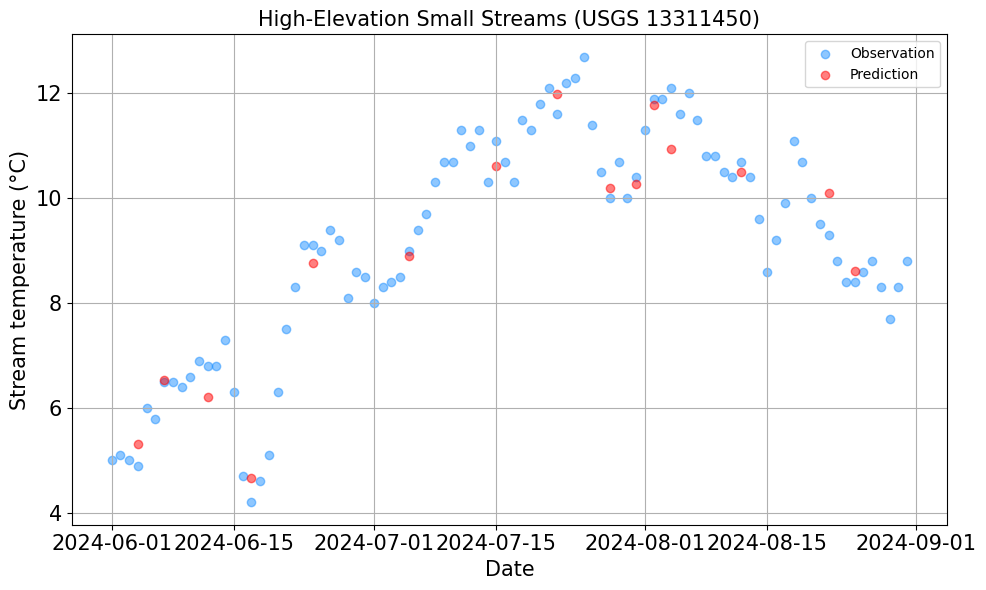

In [21]:

fontsize = 15


plt.figure(figsize=(10, 6))

df = merged_df[ merged_df['Year'] == 2024    ] 

# Blue dots: x = 'Date', y = '00010_Mean'
plt.scatter(df['Date'], df['00010_Mean'], color='dodgerblue', label='Observation', alpha=0.5)

# Red dots: x = 'Date', y = 'y_pred_best'
plt.scatter(df['Date'], df['y_pred_best'], color='red', label='Prediction', alpha=0.5)

plt.xlabel('Date' , fontsize = fontsize)
plt.ylabel('Stream temperature (°C)' , fontsize = fontsize )
plt.title( "High-Elevation Small Streams (USGS 13311450)" , fontsize = fontsize)
plt.xticks( fontsize = fontsize )
plt.yticks( fontsize = fontsize )
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig('test_pred_OBS.png')

plt.show()
